<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/main/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Define aesthetics

In [1]:
import time
t1 = time.time()
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


## Install prerequisites

In [2]:
# %%capture
!pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# !pip install -i https://pypi.org/simple/  monod  

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
     |████████████████████████████████| 4.8 MB 4.1 MB/s 
     |████████████████████████████████| 99 kB 5.9 MB/s 
     |████████████████████████████████| 96 kB 3.7 MB/s 
     |████████████████████████████████| 189 kB 46.6 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=2ee564387b3ddf80e9ebb6e593c81d6aee6ba2fee55dcfe5d337ccd1b3c5f267
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
  Created wheel for algopy: filename=algopy-0.5.7-py3-none-any.whl size=107608 sha256=fab9a8857960b9c00a20fd3bb079ecbe3dee97fa453c4170c47c35066ee86502
  Stored in directory: /root/.cache/pip/wheels/a8/fd/06/21dc6aba9f680fdbde386c06b1a8a1cf3d9a5f6bd96e31dcd4
Successfully built loompy algopy


Let's make sure that the version is correct.

In [3]:
!pip show monod

Name: monod
Version: 0.2.2.6
Summary: the Monod package fits CME models to sequencing data.
Home-page: https://github.com/pachterlab/monod
Author: Gennady Gorin, Lior Pachter
Author-email: ggorin@caltech.edu, lpachter@caltech.edu
License: None
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, numdifftools, loompy, anndata, scipy, pytz
Required-by: 


## Import data

In [4]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 686 (delta 32), reused 34 (delta 14), pack-reused 616
Receiving objects: 100% (686/686), 530.12 MiB | 21.71 MiB/s, done.
Resolving deltas: 100% (210/210), done.
Checking out files: 100% (97/97), done.


In [5]:
!rm -r sample_data

In [6]:
!mv monod_examples/* .

In [7]:
!mv sample_data/* .

In [8]:
!tar -xzvf allen_C01_gaba.tar.gz

allen_C01_gaba.loom


In [9]:
!cat allen_C01_glu.tar.gz.001 allen_C01_glu.tar.gz.002 | tar -xzv

allen_C01_glu.loom


We can construct an `anndata` object with `spliced` and `unspliced` layers, in line with standard workflows.

In [10]:
import anndata as ad

In [11]:
a = ad.read_loom('allen_C01_glu.loom')
a.write('allen_C01_glu.h5ad')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
b = ad.read_loom('allen_C01_gaba.loom')
b.write('allen_C01_gaba.h5ad')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Import package components

In [13]:
import monod
from monod.preprocess import *
from monod.extract_data import extract_data
import monod.cme_toolbox as cme_toolbox
from monod.cme_toolbox import CMEModel
import monod.inference as inference
from monod.inference import InferenceParameters, GradientInference
import monod.analysis as analysis
from monod.analysis import *

## Define metadata

In [14]:
dataset_names = ['allen_C01_gaba','allen_C01_glu'] 
loom_filepaths = ['./'+x+'.h5ad' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

In [15]:
!mkdir fits

mkdir: cannot create directory ‘fits’: File exists


## Run pre-processing

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_220615_022_mouse_1 created.
INFO:root:Dataset: allen_C01_gaba
INFO:root:1704 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6284 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_gaba created.
INFO:root:Dataset: allen_C01_glu
INFO:root:4674 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7049 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_glu created.
INFO:root:Gene set size: 5810
INFO:root:250 genes selected.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/diagnostic_figures created.


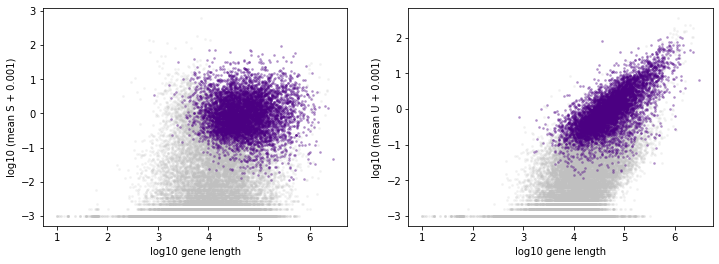

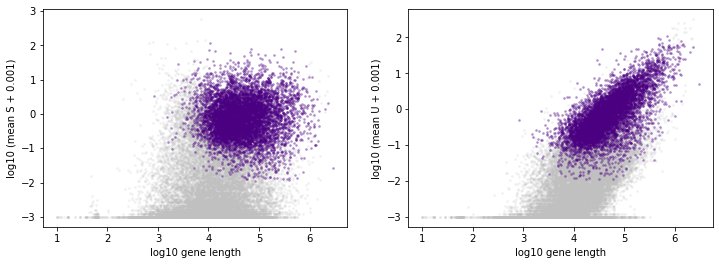

In [16]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='mouse',batch_id=1,\
                                             n_genes=250)

## Run inference

In this example, we will fit the bursty model to the two cell types, using a Poisson sampling model on a $6\times 7$ grid. For this Colaboratory notebook, we only use 5 iterations from the MoM estimate.

In [22]:
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')


INFO:root:Global inference parameters stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220615_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 2163.5 seconds.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7 created.
INFO:root:Global inference parameters stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_glu
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220615_022_mouse_1/genes.csv.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_glu/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures created.
INFO:root:Runtime: 860.6 seconds.


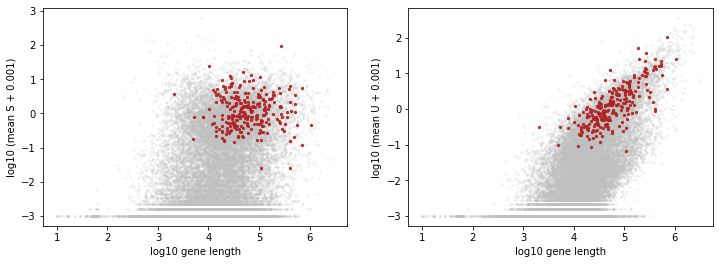

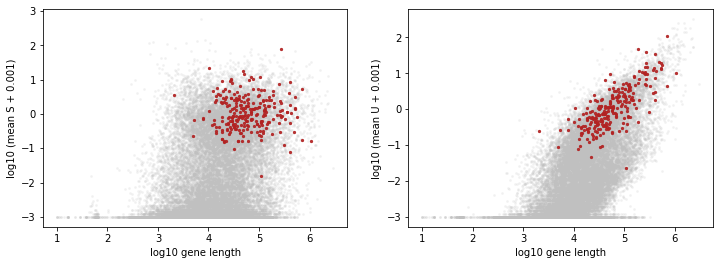

In [24]:
n_datasets = len(dataset_names)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
grid = [6,7]

result_strings = []
for i in range(n_datasets):
    fitmodel = CMEModel('Bursty','Poisson')
    inference_parameters = InferenceParameters(lb,ub,[-8, -3],[-5, 0],grid,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})
    search_data = extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                        dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(2,search_data)
    result_strings.append(full_result_string)


In [25]:
%%capture
!tar -czvf sample_fits.tar.gz fits

# Analysis

## Post-processing and QC

Load in search data.

In [26]:
sd_arr = [load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Search data loaded from ./fits/gg_220615_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220615_022_mouse_1/allen_C01_glu/raw.sd.


Inspect all bursty result files and perform basic QC. We would like to be confident of the typical results:

*   The fits successfully recapitulate the joint count distributions
*   The sampling parameters appear to have a single unique optimum in $\{C_u, \lambda_s\}$
*   The physical parameters $\{b,\beta,\gamma\}$ are largely independent of gene length
*   The physical parameter distributions are consistent with a normal-inverse Gaussian law

In [27]:
sr_arr = []
j=0

INFO:root:Grid scan results loaded from ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.7 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 5 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Re

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_220615_022_mouse_1/analysis_figures created.


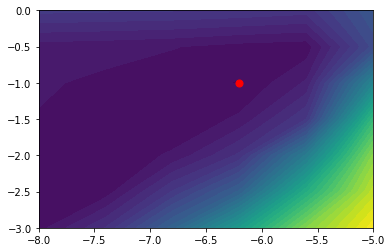

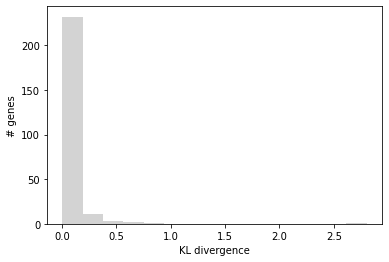

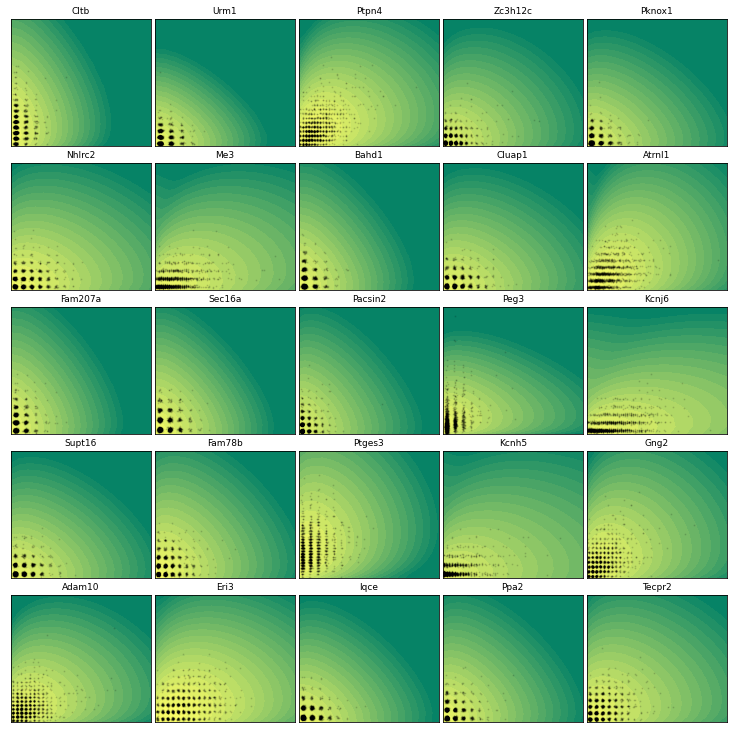

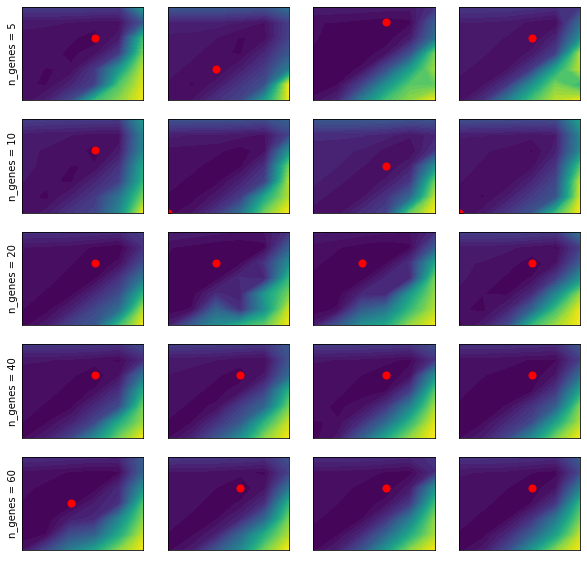

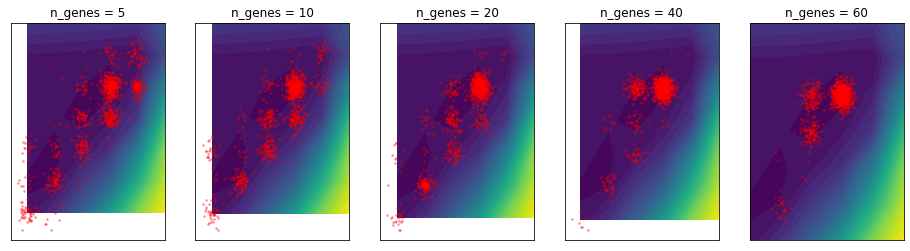

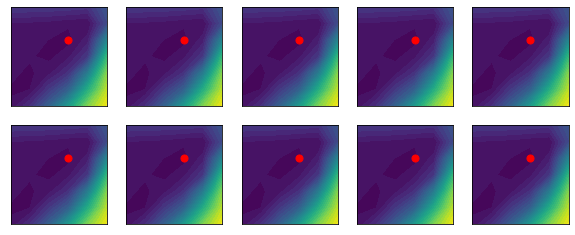

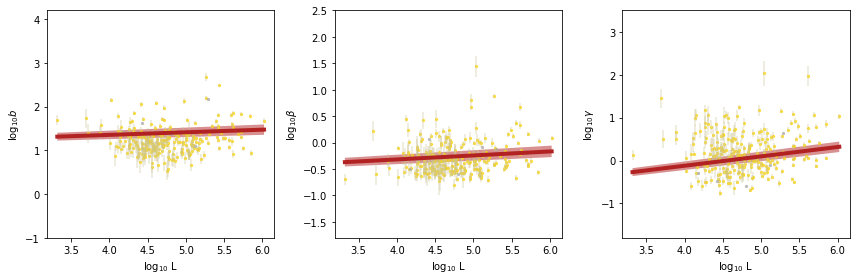

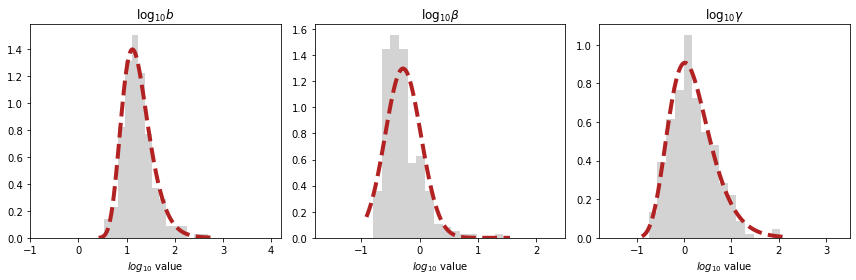

In [28]:
sr = load_search_results(result_strings[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
make_batch_analysis_dir([sr],dir_string)
sr.update_on_disk()
sr_arr.append(sr)

j+=1


INFO:root:Grid scan results loaded from ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 10 genes out of 250. Runtime: 0.5 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete.

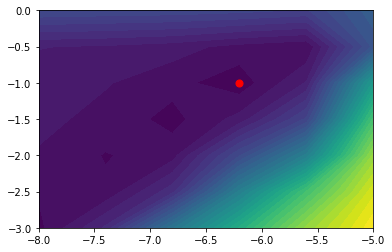

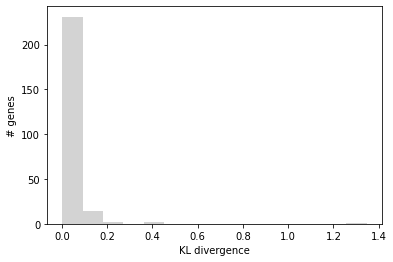

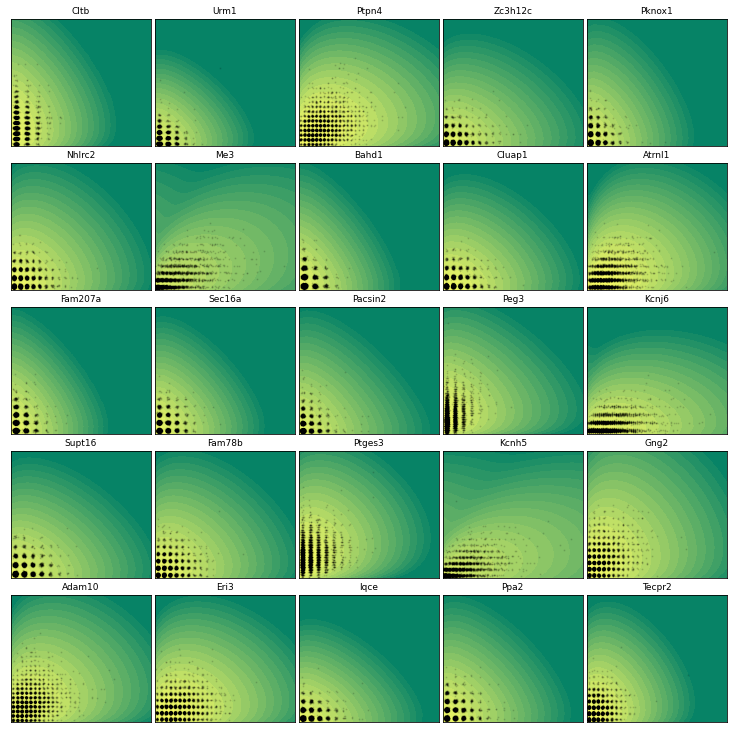

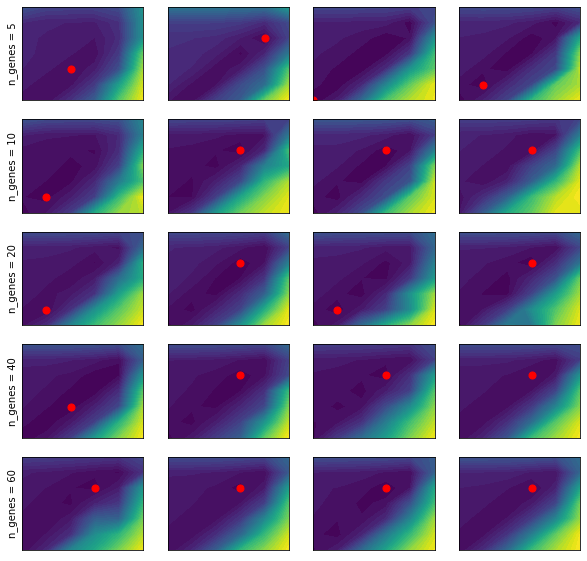

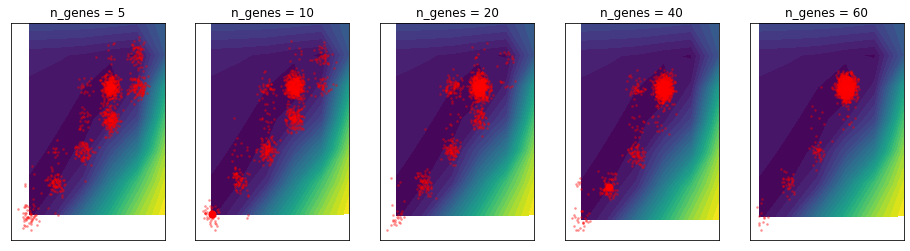

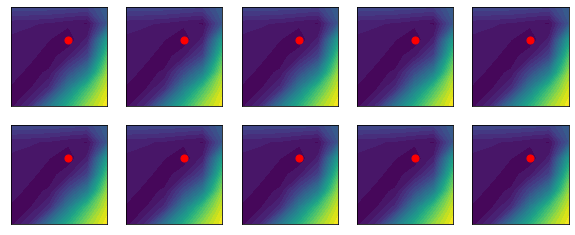

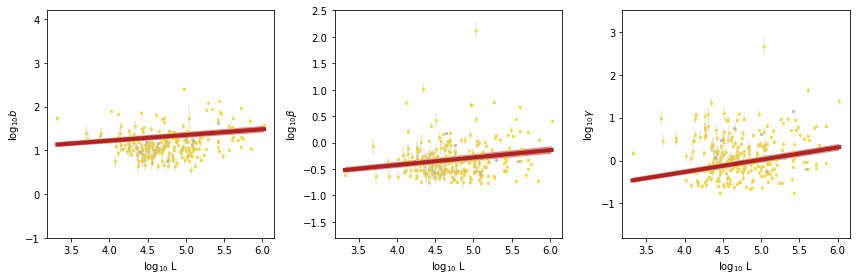

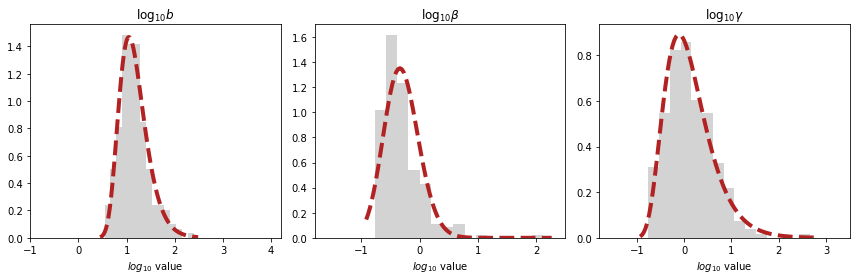

In [29]:
sr = load_search_results(result_strings[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
make_batch_analysis_dir([sr],dir_string)
sr.update_on_disk()
sr_arr.append(sr)


# Analysis of differential expression.

Load in pre-computed sample results. 

In [73]:
result_strings = ['./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res',
 './fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res']

In [74]:
# dataset_strings = ['./fits/gg_220615_022_mouse_1/allen_C01_gaba',
#  './fits/gg_220615_022_mouse_1/allen_C01_glu']


Finally, we can analyze the four mouse datasets in terms of differences between their mRNA copy number distributions, potentially suggesting differential regulation of their transcriptional processes.

In [75]:
sr_arr = [load_search_results(x) for x in result_strings]

INFO:root:Grid scan results loaded from ./fits/gg_220615_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220615_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res.


In [76]:
gn=sr_arr[0].gene_names
param_names = sr_arr[0].model.get_log_name_str()
n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 ki')
n_genes = sd_arr[0].n_genes
pval_thr = 0.1

## Standard differential expression: DE-$\mu$

The means are very similar between the datasets.

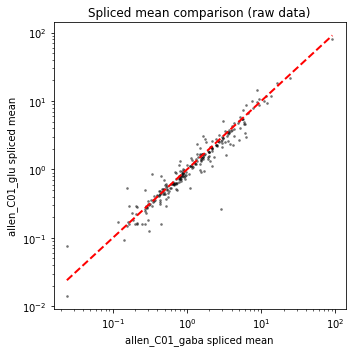

In [77]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1 = np.asarray([sd_arr[0].moments[x]['S_mean']  for x in range(n_genes)])
m2 = np.asarray([sd_arr[1].moments[x]['S_mean'] for x in range(n_genes)])
ax1.scatter(m1,m2,3,'k',alpha=0.4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Spliced mean comparison (raw data)')
xl = [min(m1),max(m1)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Raw means show changes of up to an order of magnitude.

In [78]:
print((m1/m2).min())
print((m1/m2).max())

0.28643084
10.60889


<input>:7: DeprecationWarning: invalid escape sequence \l
<input>:7: DeprecationWarning: invalid escape sequence \l
<input>:7: DeprecationWarning: invalid escape sequence \l
<input>:7: DeprecationWarning: invalid escape sequence \l
<ipython-input-79-e4c1ff6bcd3d>:7: DeprecationWarning: invalid escape sequence \l
  ax1.set_title('Normalized + $\log_2$ transformed')


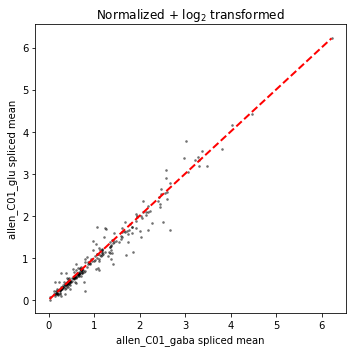

In [79]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
m1norm = normalize_count_matrix(sd_arr[0].S,logbase=2).mean(1)
m2norm = normalize_count_matrix(sd_arr[1].S,logbase=2).mean(1)
ax1.scatter(m1norm,m2norm,3,'k',alpha=0.4)
ax1.set_xlabel(dataset_names[0] + ' spliced mean')
ax1.set_ylabel(dataset_names[1] + ' spliced mean')
ax1.set_title('Normalized + $\log_2$ transformed')
xl = [min(m1norm),max(m1norm)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

The differences between means of normalized data are very small, less than a twofold change. Note we subtract here, because we have applied a $\log_2$ transformation to the raw data. 

In [80]:
print((m1norm-m2norm).min())
print((m1norm-m2norm).max())

-0.7504535
0.99815285


Accordingly, the $t$-test identifies nothing.

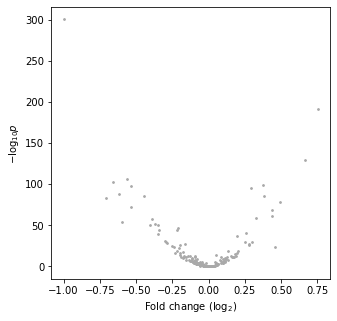

In [81]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
gf_ttest,fc_ = diffexp_mean(sd_arr[0],sd_arr[1],lognormalize=True,viz=True,method='ttest',\
                                ax1=ax1,pval_thr=pval_thr,bonferroni=True)
fig_string = sr_arr[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)


## DE-$\theta$

With the parameter fits, we can attempt to identify genes that show differences in distributions, which are not necessarily reflected in the means.

Inspect the parameter trends. These are slightly less correlated than means.

INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/analysis_figures/pair_parameter_comparison_mouse.png.


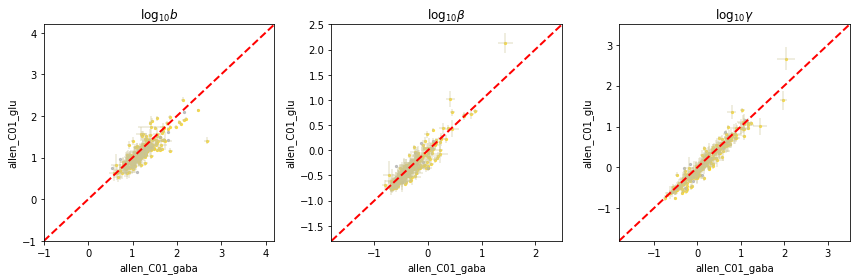

In [82]:
plot_params_for_pair(sr_arr[0],sr_arr[1],\
                        distinguish_rej=True,plot_errorbars=True,meta = 'mouse',
                        xlabel = dataset_names[0],\
                        ylabel = dataset_names[1])

A handful of genes can be identified as outliers.

INFO:root:Figure stored to ./fits/gg_220615_022_mouse_1/analysis_figures/parameter_residuals_mouse.png.


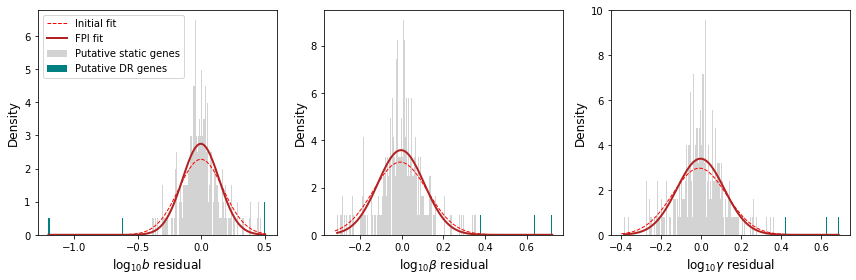

In [83]:
dr_analysis = diffexp_pars(sr_arr[0],sr_arr[1],viz=True,modeltype='id',meta= 'mouse',use_sigma=True)

In [84]:
dr_par = dr_analysis[1].T
fc_par = dr_analysis[3].T
dr_par = np.concatenate((dr_par,((dr_par[:,1] & dr_par[:,2]))[:,None]),1)
fc_par = np.concatenate((fc_par,(-(fc_par[:,1]+fc_par[:,2])/2)[:,None]),1)

What are these genes? 

In [85]:
for k in range(n_phys_pars+1):
    print(param_names_text[k])
    print(gn[dr_par[:,k]])

log10 b
['Kcnh5' 'Grin3a' 'Tsnax' 'Nos1ap']
log10 beta
['Prom1' 'Cyp46a1' 'Lipg']
log10 gamma
['Gpc6' 'Prom1' 'Lipg']
log10 ki
['Prom1' 'Lipg']


We have identified *Prom1* and *Lipg* as frequency-modulated. Is frequency modulation common in general?

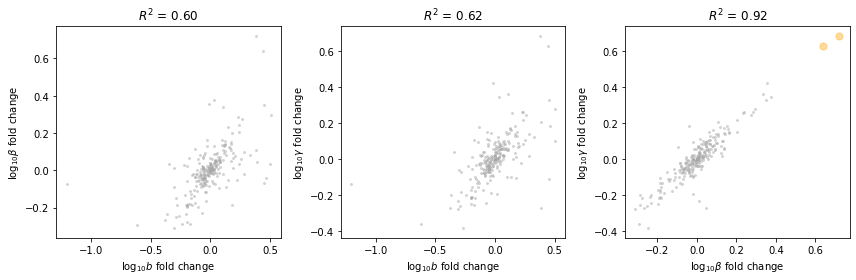

In [86]:
pairs = [[0,1],[0,2],[1,2]]
q=0
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = dr_par[:,k1] & dr_par[:,k2]

    x = fc_par[:,k1]
    y = fc_par[:,k2]
    x[np.isnan(x)] = 0 
    y[np.isnan(y)] = 0

    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change')
    ax1[q].set_ylabel(param_names[k2]+' fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


## Raw data examination

### Burst size

Do the fit distributions actually match the data? First, consider those assigned to burst size modulation.

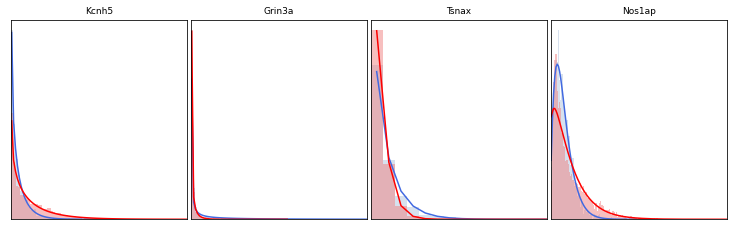

In [87]:
gf = dr_par[:,0]
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,4),figsize=(10,3))

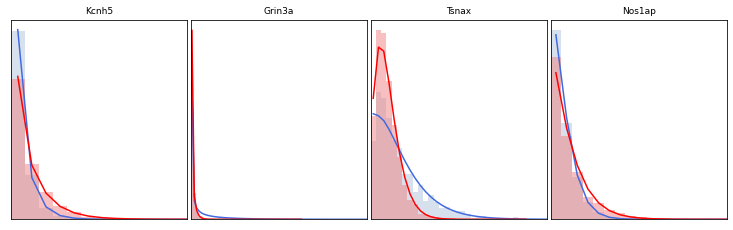

In [88]:
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,4),figsize=(10,3))

They appear to match the data fairly well, altough *Tsnax* shows some subtle deviations in the mature mRNA distribution.

How much do the parameters change? The model predicts above 0.5 absolute $\log_2$ change.

In [89]:
fc_par[gf][:,0]

array([ 0.50143858, -1.20509609, -0.61811646,  0.50395114])

How much do the means change? After normalization, less than 0.6.

In [90]:
fc_[gf]

array([ 0.37511167, -0.5948716 , -0.53329706,  0.25244164], dtype=float32)

Raw averages do change more than twofold for *Grin3a*.

In [91]:
(m1/m2)[gf]

array([ 0.39926505, 10.60889   ,  1.851147  ,  0.6057328 ], dtype=float32)

### Burst frequency

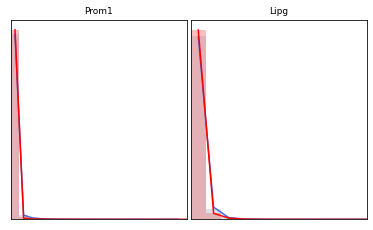

In [92]:
gf = dr_par[:,3]
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,2),figsize=(5,3))

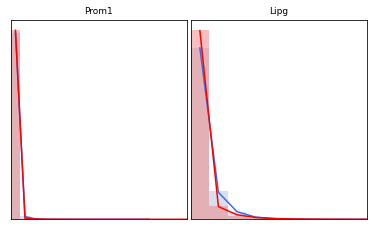

In [93]:
compare_gene_distributions([sr_arr[0],sr_arr[1]], [sd_arr[0],sd_arr[1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,2),figsize=(5,3))

The differences for frequency-modulated genes are more subtle. They predict approximately $\log_2$ fold change of -0.65 from GABAergic to glutamatergic.  The $\log_2$ fold change between averages after normalization is less than 0.1.

In [94]:
fc_par[gf][:,3]

array([-0.70450135, -0.63331379])

In [95]:
fc_[gf]

array([-0.01853234, -0.09296803], dtype=float32)

If we look at the difference between raw averages, it is less than twofold.

In [96]:
(m1/m2)[gf]

array([1.7039586, 1.5611515], dtype=float32)

In [97]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_220604_022_mouse_1/
fits/gg_220604_022_mouse_1/allen_C01_glu/
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results_upd.res
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/parameters.pr
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/grid_scan_results.res
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/chisquare_stability.png
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/kldiv.png
fits/gg_220604_022_mouse_1/allen_C01_glu/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png
fits/gg_220604_022_mouse_1/allen_C01_glu/Burs